In [1]:
import os
import sys
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('..')
from semilearn.core.utils import get_net_builder, get_dataset, over_write_args_from_file
from semilearn.algorithms.openmatch.openmatch import OpenMatchNet
from semilearn.algorithms.iomatch.iomatch import IOMatchNet

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--c', type=str, default='')

def load_model_at(step='best'):
    args.step = step
    if step == 'best':
        args.load_path = '/'.join(args.load_path.split('/')[1:-1]) + "/model_best.pth"
    else:
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/model_at_{args.step}_step.pth"
    print(args.load_path)
    checkpoint_path = os.path.join(args.load_path)
    checkpoint = torch.load(checkpoint_path)
    load_model = checkpoint['ema_model']
    load_state_dict = {}
    for key, item in load_model.items():
        if key.startswith('module'):
            new_key = '.'.join(key.split('.')[1:])
            load_state_dict[new_key] = item
        else:
            load_state_dict[key] = item
    save_dir = '/'.join(checkpoint_path.split('/')[:-1])
    if step == 'best':
        args.save_dir = os.path.join(save_dir, f"model_best")
    else:
        args.save_dir = os.path.join(save_dir, f"step_{args.step}")
    os.makedirs(args.save_dir, exist_ok=True)
    _net_builder = get_net_builder(args.net, args.net_from_name)
    net = _net_builder(num_classes=args.num_classes)
    if args.algorithm == 'openmatch':
        net = OpenMatchNet(net, args.num_classes)
    elif args.algorithm == 'iomatch':
        net = IOMatchNet(net, args.num_classes)
    else:
        raise NotImplementedError
    keys = net.load_state_dict(load_state_dict)
    print(f'Model at step {args.step} loaded!')
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    return net

In [3]:
def evaluate_open(net, dataset_dict, num_classes, extended_test=True):
    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=4)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    y_pred_closed_list = []
    y_pred_ova_list = []
    
    results = {}
    
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()

            num_batch = y.shape[0]
            total_num += num_batch
            
            out = net(x)
            logits, logits_open = out['logits'], out['logits_open']    
            pred_closed = logits.data.max(1)[1]
            
            probs = F.softmax(logits, 1)
            probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
            unk_score = probs_open[tmp_range, 0, pred_closed]
            pred_open = pred_closed.clone()
            pred_open[unk_score > 0.5] = num_classes

            y_true_list.extend(y.cpu().tolist())
            y_pred_closed_list.extend(pred_closed.cpu().tolist())
            y_pred_ova_list.extend(pred_open.cpu().tolist())

    y_true = np.array(y_true_list)

    closed_mask = y_true < num_classes
    open_mask = y_true >= num_classes
    y_true[open_mask] = num_classes

    y_pred_closed = np.array(y_pred_closed_list)
    y_pred_ova = np.array(y_pred_ova_list)

    # Closed Accuracy on Closed Test Data
    y_true_closed = y_true[closed_mask]
    y_pred_closed = y_pred_closed[closed_mask]
    closed_acc = accuracy_score(y_true_closed, y_pred_closed)
    closed_cfmat = confusion_matrix(y_true_closed, y_pred_closed, normalize='true')
    results['c_acc_c_p'] = closed_acc
    results['c_cfmat_c_p'] = closed_cfmat  

    # Open Accuracy on Full Test Data
    open_acc = balanced_accuracy_score(y_true, y_pred_ova)
    open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
    results['o_acc_f_hq'] = open_acc  
    results['o_cfmat_f_hq'] = open_cfmat
        
    if extended_test:
        with torch.no_grad():
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()

                num_batch = y.shape[0]
                total_num += num_batch

                out = net(x)
                logits, logits_open = out['logits'], out['logits_open']    
                pred_closed = logits.data.max(1)[1]

                probs = F.softmax(logits, 1)
                probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
                unk_score = probs_open[tmp_range, 0, pred_closed]
                pred_open = pred_closed.clone()
                pred_open[unk_score > 0.5] = num_classes

                y_true_list.extend(y.cpu().tolist())
                y_pred_closed_list.extend(pred_closed.cpu().tolist())
                y_pred_ova_list.extend(pred_open.cpu().tolist())
            
        y_true = np.array(y_true_list)

        open_mask = y_true >= num_classes
        y_true[open_mask] = num_classes
        y_pred_ova = np.array(y_pred_ova_list)
        
        # Open Accuracy on Extended Test Data
        open_acc = balanced_accuracy_score(y_true, y_pred_ova)
        open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
        results['o_acc_e_hq'] = open_acc  
        results['o_cfmat_e_hq'] = open_cfmat
    
    print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data: {results['c_acc_c_p'] * 100:.2f}\n"
              f" Open Accuracy on Full Test Data:     {results['o_acc_f_hq'] * 100:.2f}\n"
              f" Open Accuracy on Extended Test Data: {results['o_acc_e_hq'] * 100:.2f}\n"
              f"#############################################################\n"
        )
    
    return results

In [4]:
def evaluate_io(args, net, dataset_dict, extended_test=True):
    """
    evaluation function for open-set SSL setting
    """

    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=4)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    p_list = []
    pred_p_list = []
    pred_hat_q_list = []
    pred_q_list = []
    pred_hat_p_list = []

    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()
            y_true_list.extend(y.cpu().tolist())

            num_batch = y.shape[0]
            total_num += num_batch

            outputs = net(x)
            logits = outputs['logits']
            logits_mb = outputs['logits_mb']
            logits_open = outputs['logits_open']

            # predictions p of closed-set classifier
            p = F.softmax(logits, 1)
            pred_p = p.data.max(1)[1]
            pred_p_list.extend(pred_p.cpu().tolist())

            # predictions hat_q from (closed-set + multi-binary) classifiers
            r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
            hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
            o_neg = r[tmp_range, 0, :]
            o_pos = r[tmp_range, 1, :]
            hat_q[:, :args.num_classes] = p * o_pos
            hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
            pred_hat_q = hat_q.data.max(1)[1]
            pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

            # predictions q of open-set classifier
            q = F.softmax(logits_open, 1)
            pred_q = q.data.max(1)[1]
            pred_q_list.extend(pred_q.cpu().tolist())

            # prediction hat_p of open-set classifier
            hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
            pred_hat_p = hat_p.data.max(1)[1]
            pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

        y_true = np.array(y_true_list)
        closed_mask = y_true < args.num_classes
        open_mask = y_true >= args.num_classes
        y_true[open_mask] = args.num_classes


        pred_p = np.array(pred_p_list)
        pred_hat_p = np.array(pred_hat_p_list)
        pred_q = np.array(pred_q_list)
        pred_hat_q = np.array(pred_hat_q_list)

        # closed accuracy of p / hat_p on closed test data
        c_acc_c_p = accuracy_score(y_true[closed_mask], pred_p[closed_mask])
        c_acc_c_hp = accuracy_score(y_true[closed_mask], pred_hat_p[closed_mask])
        c_cfmat_c_p = confusion_matrix(y_true[closed_mask], pred_p[closed_mask], normalize='true')
        c_cfmat_c_hp = confusion_matrix(y_true[closed_mask], pred_hat_p[closed_mask], normalize='true')
        np.set_printoptions(precision=3, suppress=True)

        # open accuracy of q / hat_q on full test data
        o_acc_f_q = balanced_accuracy_score(y_true, pred_q)
        o_acc_f_hq = balanced_accuracy_score(y_true, pred_hat_q)
        o_cfmat_f_q = confusion_matrix(y_true, pred_q, normalize='true')
        o_cfmat_f_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        o_acc_e_q = o_acc_e_hq = 0
        o_cfmat_e_q = None
        o_cfmat_e_hq = None

        if extended_test:
            unk_scores = []
            unk_scores_q = []
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()
                y_true_list.extend(y.cpu().tolist())

                num_batch = y.shape[0]
                total_num += num_batch

                outputs = net(x)
                logits = outputs['logits']
                logits_mb = outputs['logits_mb']
                logits_open = outputs['logits_open']

                # predictions p of closed-set classifier
                p = F.softmax(logits, 1)
                pred_p = p.data.max(1)[1]
                pred_p_list.extend(pred_p.cpu().tolist())

                # predictions hat_q of (closed-set + multi-binary) classifiers
                r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
                hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
                o_neg = r[tmp_range, 0, :]
                o_pos = r[tmp_range, 1, :]
                unk_score = torch.sum(p * o_neg, 1)
                hat_q[:, :args.num_classes] = p * o_pos
                hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
                pred_hat_q = hat_q.data.max(1)[1]
                pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

                # predictions q of open-set classifier
                q = F.softmax(logits_open, 1)
                pred_q = q.data.max(1)[1]
                pred_q_list.extend(pred_q.cpu().tolist())

                # prediction hat_p of open-set classifier
                hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
                pred_hat_p = hat_p.data.max(1)[1]
                pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

            y_true = np.array(y_true_list)
            open_mask = y_true >= args.num_classes
            y_true[open_mask] = args.num_classes

            pred_q = np.array(pred_q_list)
            pred_hat_q = np.array(pred_hat_q_list)

            # open accuracy of q / hat_q on extended test data
            o_acc_e_q = balanced_accuracy_score(y_true, pred_q)
            o_acc_e_hq = balanced_accuracy_score(y_true, pred_hat_q)
            o_cfmat_e_q = confusion_matrix(y_true, pred_q, normalize='true')
            o_cfmat_e_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        eval_dict = {'c_acc_c_p': c_acc_c_p, 'c_acc_c_hp': c_acc_c_hp,
                     'o_acc_f_q': o_acc_f_q, 'o_acc_f_hq': o_acc_f_hq,
                     'o_acc_e_q': o_acc_e_q, 'o_acc_e_hq': o_acc_e_hq,
                     'c_cfmat_c_p': c_cfmat_c_p, 'c_cfmat_c_hp': c_cfmat_c_hp,
                     'o_cfmat_f_q': o_cfmat_f_q, 'o_cfmat_f_hq': o_cfmat_f_hq,
                     'o_cfmat_e_q': o_cfmat_e_q, 'o_cfmat_e_hq': o_cfmat_e_hq,
                    }

        print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data (p / hp): {c_acc_c_p * 100:.2f} / {c_acc_c_hp * 100:.2f}\n"
              f" Open Accuracy on Full Test Data (q / hq):     {o_acc_f_q * 100:.2f} / {o_acc_f_hq * 100:.2f}\n"
              f" Open Accuracy on Extended Test Data (q / hq): {o_acc_e_q * 100:.2f} / {o_acc_e_hq * 100:.2f}\n"
              f"#############################################################\n"
            )

        return eval_dict

In [5]:
args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/iomatch_cifar100_200_1.yaml'])
over_write_args_from_file(args, args.c)
args.data_dir = 'data'
dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=True)
best_net = load_model_at('best')
eval_dict = evaluate_io(args, best_net, dataset_dict)

saved_models/openset_cv/iomatch_cifar100_200_1/model_best.pth
Model at step best loaded!


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


#############################################################
 Closed Accuracy on Closed Test Data (p / hp): 56.14 / 55.92
 Open Accuracy on Full Test Data (q / hq):     46.29 / 46.10
 Open Accuracy on Extended Test Data (q / hq): 45.89 / 45.79
#############################################################



In [6]:
args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/iomatch_cifar100_1250_1.yaml'])
over_write_args_from_file(args, args.c)
args.data_dir = 'data'
dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=True)
best_net = load_model_at('best')
eval_dict = evaluate_io(args, best_net, dataset_dict)

saved_models/openset_cv/iomatch_cifar100_1250_1/model_best.pth
Model at step best loaded!


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


#############################################################
 Closed Accuracy on Closed Test Data (p / hp): 69.84 / 69.80
 Open Accuracy on Full Test Data (q / hq):     61.54 / 60.85
 Open Accuracy on Extended Test Data (q / hq): 61.20 / 60.57
#############################################################



<Figure size 640x480 with 0 Axes>

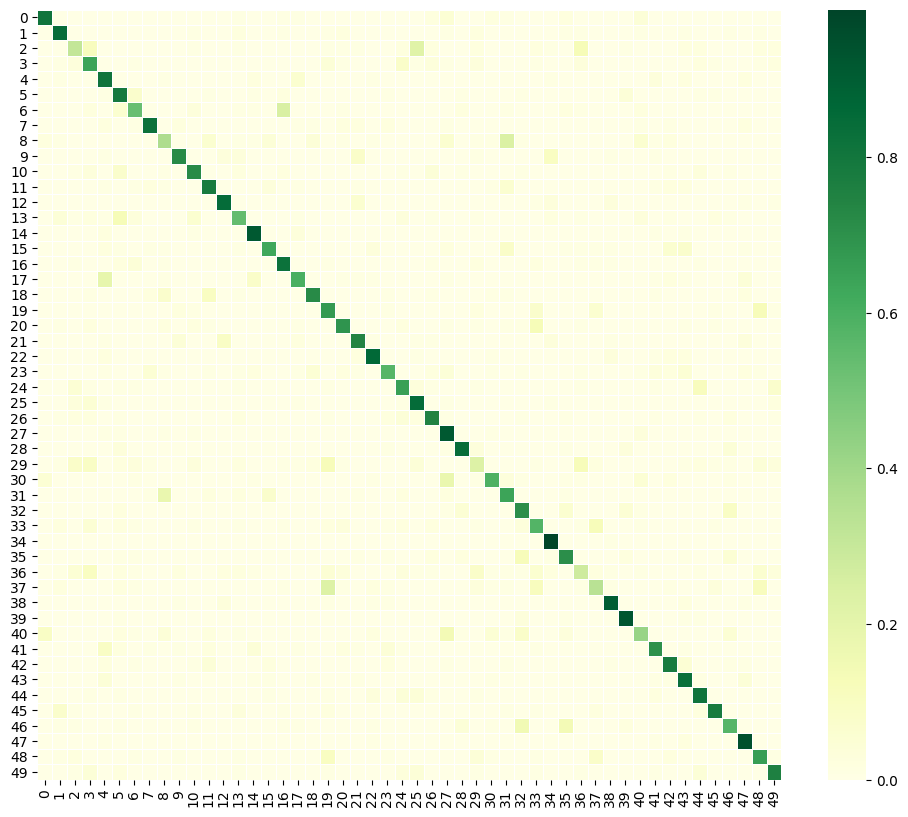

In [7]:
# Confusion matrix of closed-set classification (IOMatch-CIFAR-50-1250)
fig = plt.figure()
f, ax = plt.subplots(figsize=(12,10))
cf_mat = eval_dict['c_cfmat_c_p']
ax = sns.heatmap(cf_mat, cmap='YlGn', linewidth=0.5)
plt.show()

<Figure size 640x480 with 0 Axes>

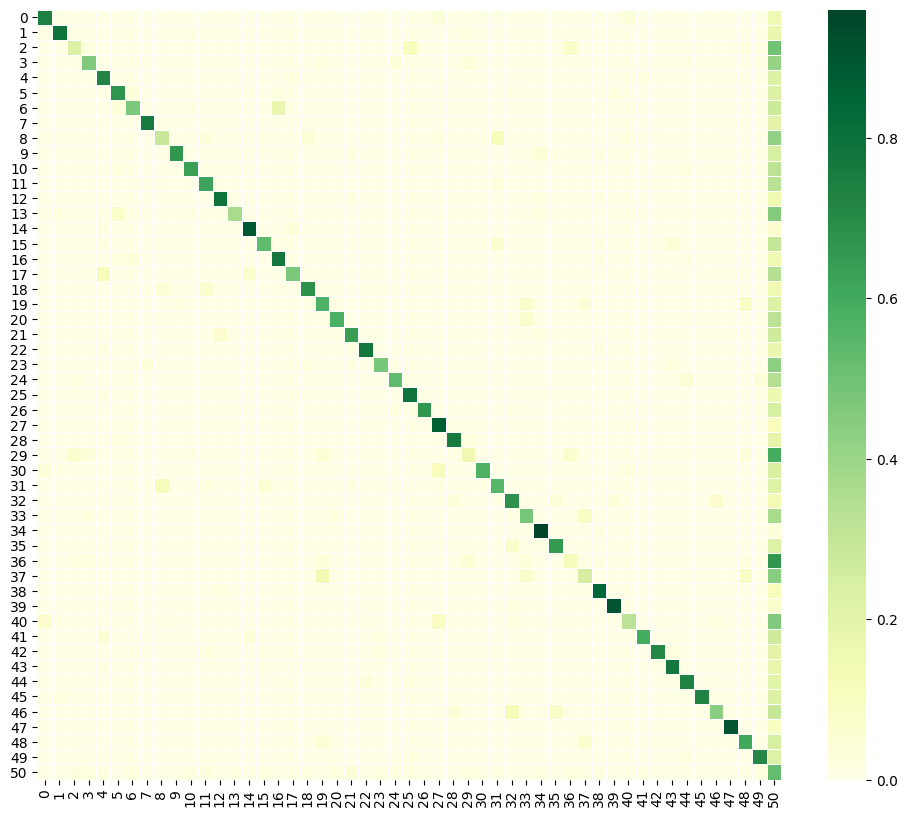

In [8]:
# Confusion matrix of open-set classification (IOMatch-CIFAR-50-1250)
fig = plt.figure()
f, ax = plt.subplots(figsize=(12,10))
cf_mat = eval_dict['o_cfmat_f_q']
ax = sns.heatmap(cf_mat, cmap='YlGn', linewidth=0.5)
plt.show()

In [9]:
args = parser.parse_args(args=['--c', 'config/openset_cv/openmatch/openmatch_cifar100_200_1.yaml'])
over_write_args_from_file(args, args.c)
args.data_dir = 'data'
dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=True)
best_net = load_model_at('best')
eval_dict = evaluate_open(best_net, dataset_dict, num_classes=args.num_classes)

saved_models/openset_cv/openmatch_cifar100_200_1/model_best.pth
Model at step best loaded!


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


#############################################################
 Closed Accuracy on Closed Test Data: 34.12
 Open Accuracy on Full Test Data:     6.97
 Open Accuracy on Extended Test Data: 6.98
#############################################################



<Figure size 640x480 with 0 Axes>

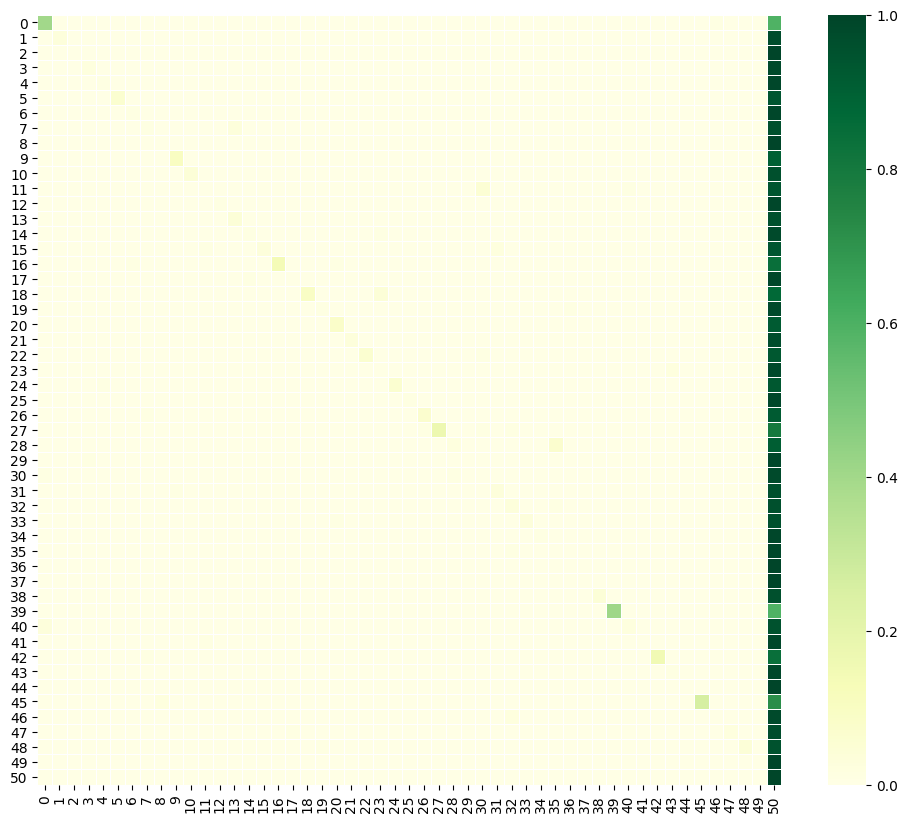

In [10]:
# Confusion matrix of open-set classification (OpenMatch-CIFAR-50-200)
fig = plt.figure()
f, ax = plt.subplots(figsize=(12,10))
cf_mat = eval_dict['o_cfmat_f_hq']
ax = sns.heatmap(cf_mat, cmap='YlGn', linewidth=0.5)
plt.show()

In [11]:
args = parser.parse_args(args=['--c', 'config/openset_cv/openmatch/openmatch_cifar100_1250_1.yaml'])
over_write_args_from_file(args, args.c)
args.data_dir = 'data'
dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=True)
best_net = load_model_at('best')
eval_dict = evaluate_open(best_net, dataset_dict, num_classes=args.num_classes)

saved_models/openset_cv/openmatch_cifar100_1250_1/model_best.pth
Model at step best loaded!


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


#############################################################
 Closed Accuracy on Closed Test Data: 66.04
 Open Accuracy on Full Test Data:     49.66
 Open Accuracy on Extended Test Data: 49.08
#############################################################



<Figure size 640x480 with 0 Axes>

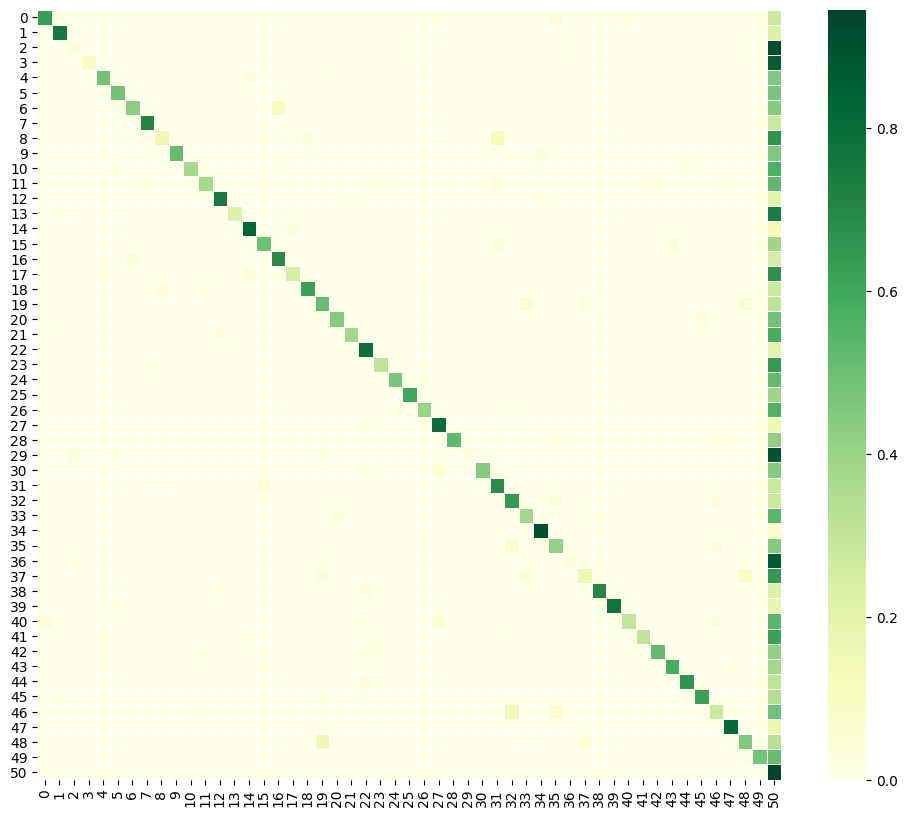

In [12]:
# Confusion matrix of open-set classification (OpenMatch-CIFAR-50-1250)
fig = plt.figure()
f, ax = plt.subplots(figsize=(12,10))
cf_mat = eval_dict['o_cfmat_f_hq']
ax = sns.heatmap(cf_mat, cmap='YlGn', linewidth=0.5)
plt.show()